Make sure that the tail part of the forward model applied to the (mock) observations is perfectly consistent with what happens within the main CosmoGrid forward model (both for fiducial and grid cosmologies)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, h5py
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)

os.environ["OMP_NUM_THREADS"] = str(len(os.sched_getaffinity(0)))
import healpy as hp

from msfm.fiducial_pipeline import FiducialPipeline
from msfm.utils import files, redshift, clustering, lensing, maps, observation

2026-02-19 02:14:52.467964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-19 02:14:52.467992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-19 02:14:52.469383: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-19 02:14:52.478057: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-19 02:14:53.564670: W tensorflow/compiler/tf2

# select version

In [3]:
# # v14
# conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v14/extended.yaml"
# tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v14/extended/tfrecords/fiducial/DESy3_fiducial_dmb_0000.tfrecord"

In [4]:
# # v15
# conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v15/extended.yaml"
# tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v15/extended/tfrecords/fiducial/DESy3_fiducial_dmb_0000.tfrecord"

In [5]:
# v16
conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v16/simple.yaml"
tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v16/default/tfrecords/fiducial/DESy3_fiducial_dmb_0000.tfrecord"

In [6]:
conf = files.load_config(conf)

metacal_bins = conf["survey"]["metacal"]["z_bins"]
maglim_bins = conf["survey"]["maglim"]["z_bins"]
n_z = len(metacal_bins) + len(maglim_bins)

# pixels
n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]
data_vec_pix, patches_pix_dict, corresponding_pix_dict, _ = files.load_pixel_file(conf)
data_vec_len = len(data_vec_pix)

# gnomview
x_deg = 10
y_deg = x_deg

x_pix = 600
y_pix = x_pix

# in arcminute / pixel
reso = x_deg / x_pix * 60

# for the rotated DES footprint
rot = (90, -30, 0)

# from .tfrecord

In [7]:
fidu_pipe = FiducialPipeline(
    conf=conf,
    params=[],
    with_lensing=True,
    with_clustering=True,
    with_padding=True,
    apply_norm=False,
    apply_m_bias=False,
    shape_noise_scale=0.0,
    poisson_noise_scale=0.0,
)

26-02-19 02:14:57 base_pipelin WAR   The noise scaling is only implemented for the maps, not the power spectra 


2026-02-19 02:14:58.363986: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16101 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [8]:
fidu_dset = fidu_pipe.get_dset(
    tfr_pattern=tfr_pattern,
    local_batch_size=1,
    noise_indices=10,
    n_readers=1,
    examples_shuffle_buffer=None,
    n_prefetch=None,
    is_eval=True,
)

for dv, _, index in fidu_dset.take(1):
    i_example = index[0].numpy()
    i_noise = index[1].numpy()

    print(f"i_example = {i_example}, i_noise = {i_noise}")

print(dv.shape)

26-02-19 02:14:58 fiducial_pip WAR   Evaluation mode is activated: the random seed is fixed, the shuffle arguments ignored, and the dataset is not repeated 
26-02-19 02:14:58 fiducial_pip INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
26-02-19 02:14:58 fiducial_pip INF   drop_remainder is not set, using drop_remainder = False 
26-02-19 02:14:58 fiducial_pip INF   Including noise_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
26-02-19 02:14:58 fiducial_pip INF   Interleaving with n_readers = 1 
26-02-19 02:14:59 fiducial_pip INF   Batching into 1 elements locally with drop_remainder = False 
26-02-19 02:15:00 fiducial_pip WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warnin

# from .h5

In [9]:
h5_dir = "/global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/fiducial/cosmo_fiducial/perm_0000"

wl_gamma_map, gc_count_map = observation.forward_model_cosmogrid(
    h5_dir,    
    conf=conf,
    with_lensing=True,
    with_clustering=True,
    noisy=False,
)

26-02-19 02:15:03 observation. INF   Loading the full-sky map from /global/cfs/cdirs/des/cosmogrid/processed/v11desy3/CosmoGrid/bary/fiducial/cosmo_fiducial/perm_0000/projected_probes_maps_v11dmb.h5 
26-02-19 02:15:03 observation. INF   Starting with the weak lensing map 
26-02-19 02:15:39 observation. INF   Using tomo_Aia=[0.35989797 0.44188944 0.55791044 0.6524075 ] from the config 
26-02-19 02:15:39 observation. INF   Using bta=None from the function call 
26-02-19 02:15:39 observation. INF   Using standard NLA 
26-02-19 02:15:51 observation. INF   Finished weak lensing after 0:00:47.82 
26-02-19 02:15:51 observation. INF   Starting with the galaxy clustering map 
26-02-19 02:16:09 observation. INF   Using tomo_bg=[1.3433586 1.4218498 1.4996815 1.5668583] from the config 
26-02-19 02:16:09 observation. INF   No quadratic biasing 
26-02-19 02:16:09 observation. INF   Finished galaxy clustering after 0:00:18.64 


In [10]:
h5_obs, h5_obs_cls, _ = observation.forward_model_observation_map(
    conf=conf,
    wl_gamma_map=wl_gamma_map,
    gc_count_map=gc_count_map,
    apply_norm=False,
    with_padding=True,
    nest_in=False,
)

# comparison

In [11]:
# .tfrecord
tf_map = np.zeros((n_pix, n_z))
tf_map[data_vec_pix] = dv[0]

# # original .h5
# h5_original_map = maps.tomographic_reorder(h5_original.copy(), r2n=True)

# forward modeled .h5
h5_obs_map = np.zeros((n_pix, n_z))
h5_obs_map[data_vec_pix] = h5_obs

# differences
# without_obs_fm = tf_map - h5_original_map
with_obs_fm = tf_map - h5_obs_map

print(np.mean(tf_map, axis=0) / np.mean(h5_obs_map, axis=0))

[1.00001508 0.99998943 0.99999044 1.00001396 1.00000005 0.99999997
 1.00000002 1.00000007]


### weak lensing

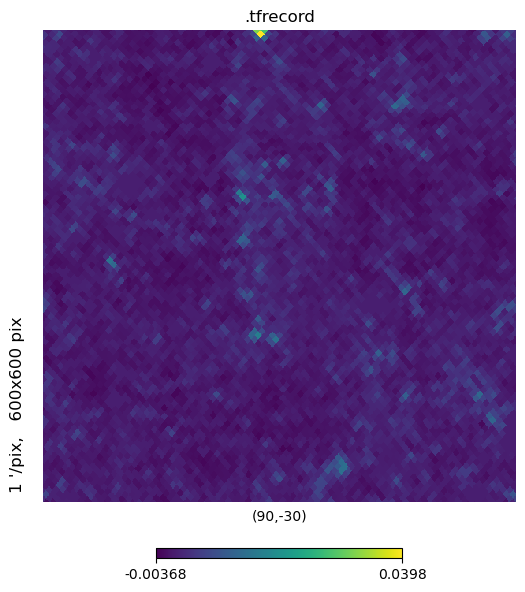

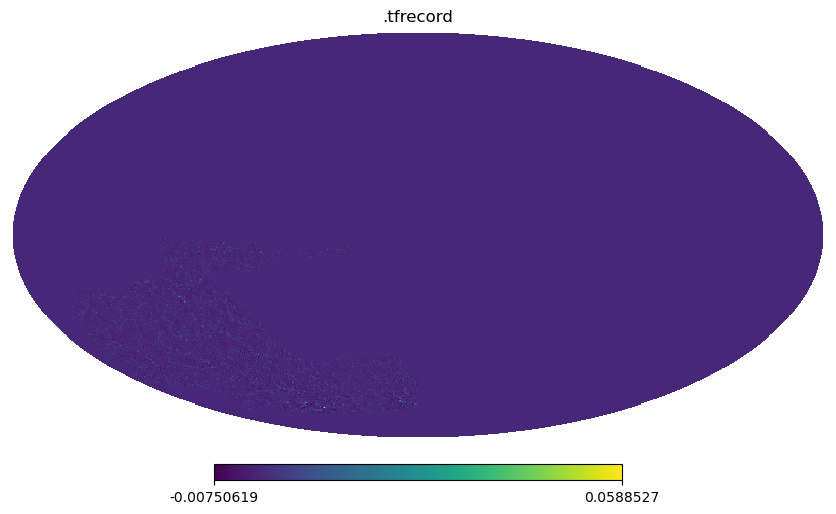

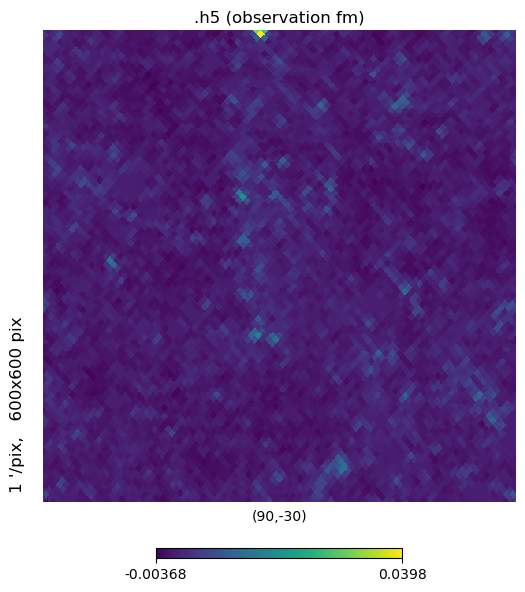

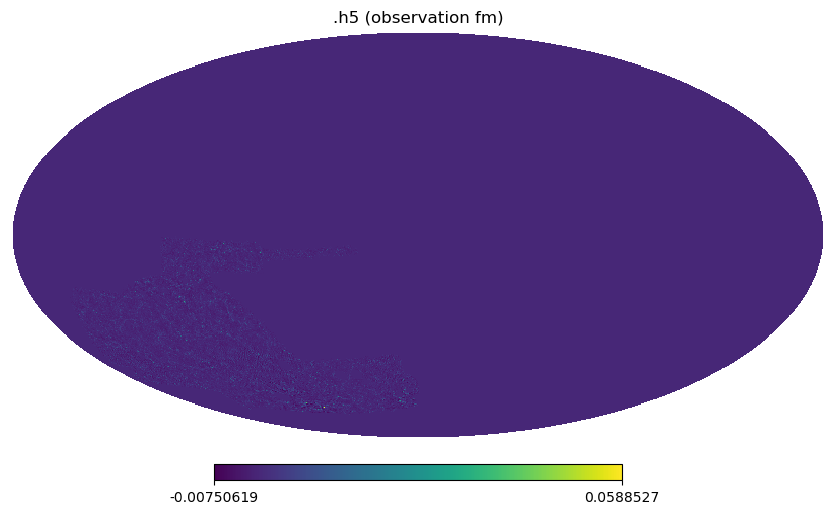

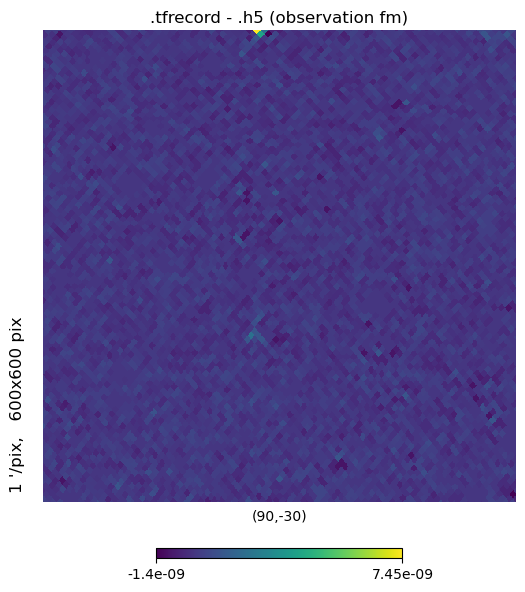

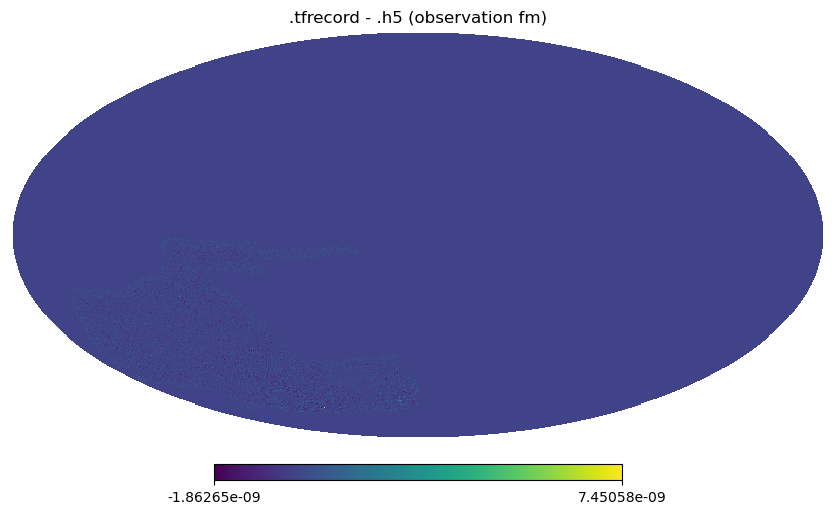

In [12]:
# weak lensing in [0,1,2,3], galaxy clustering in [4,5,6,7]
i_z = 0

# .tfrecord
hp.gnomview(tf_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord")
hp.mollview(tf_map[:,i_z], nest=True, title=".tfrecord")

# forward modeled .h5
hp.gnomview(h5_obs_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".h5 (observation fm)")
hp.mollview(h5_obs_map[:,i_z], nest=True, title=".h5 (observation fm)")

# differences
hp.gnomview(with_obs_fm[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord - .h5 (observation fm)")
hp.mollview(with_obs_fm[:,i_z], nest=True, title=".tfrecord - .h5 (observation fm)")

# original .h5
# hp.gnomview(h5_original_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".h5 (original)")
# hp.gnomview(without_obs_fm[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord - .h5 (original)")

### galaxy clustering

In [13]:
tf_map.shape

(3145728, 8)

In [14]:
h5_obs_map.shape

(3145728, 8)

In [15]:
np.mean(tf_map, axis=0)

array([3.88754484e-07, 4.67431085e-07, 4.86499010e-07, 2.87845428e-07,
       1.08467359e-01, 7.68892084e-02, 7.85587262e-02, 1.03928980e-01])

In [16]:
np.mean(h5_obs_map - tf_map, axis=0)

array([-5.86106829e-12,  4.93989971e-12,  4.65181350e-12, -4.01847019e-12,
       -4.96582863e-09,  2.44468826e-09, -1.78407588e-09, -6.82700014e-09])

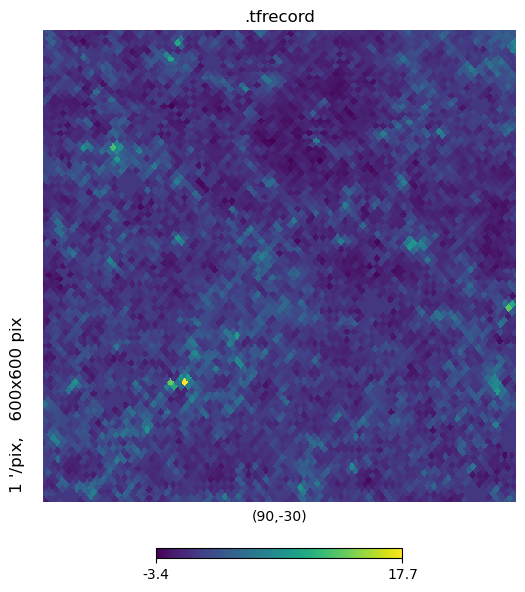

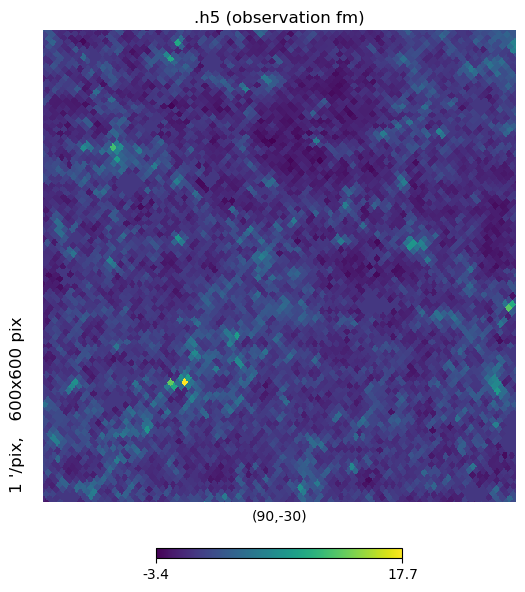

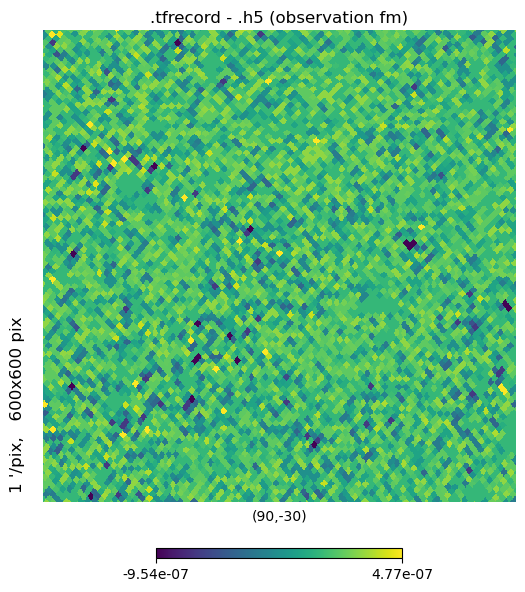

In [17]:
# weak lensing in [0,1,2,3], galaxy clustering in [4,5,6,7]
i_z = 5

# .tfrecord
hp.gnomview(tf_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord")
# hp.mollview(tf_map[:,i_z], nest=True, title=".tfrecord")

# forward modeled .h5
hp.gnomview(h5_obs_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".h5 (observation fm)")
# hp.mollview(h5_obs_map[:,i_z], nest=True, title=".tfrecord")

# differences
hp.gnomview(with_obs_fm[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord - .h5 (observation fm)")
# hp.mollview(with_obs_fm[:,i_z], nest=True, title=".tfrecord")

# hp.gnomview((h5_obs_map[:,i_z] - np.mean(h5_obs_map[:,i_z]) - (tf_map[:,i_z] - np.mean(tf_map[:,i_z]))), nest=True, title=".tfrecord - .h5 (observation fm) and means")
# hp.gnomview(without_mean[:,i_z], nest=True, title=".tfrecord - .h5 (observation fm) without means")


# hp.gnomview(tf_map[:,i_z]-h5_obs_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord / .h5 (observation fm)")
# hp.gnomview(tf_map[:,i_z]/h5_obs_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord / .h5 (observation fm)")
# hp.gnomview(h5_obs_map[:,i_z]/tf_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".h5 (observation fm) / .tfrecord")

# # original .h5
# hp.gnomview(h5_original_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".h5 (original)")
# # hp.gnomview(without_obs_fm[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord - .h5 (original)")